# Project5: Niraj 
## Modeling Accident time series - Vector AutoRegression model


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.api import VAR


In [213]:
# Read the saved csv from the earlier notebook and set the index to the date_time column

df_accident_ts = pd.read_csv("./data/accident_ts_10years.csv", parse_dates= ['date_time'], index_col="date_time")

/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (3,6,8,11,20,24,26,28,30,32,34,36,38,40,42,44,48,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [214]:
df_accident_ts.reset_index()
df_accident_ts.sort_index(inplace=True)

In [64]:
# Drop Unnamed column if it exists
#df_accident_ts.drop(columns="Unnamed: 0", inplace=True)

In [218]:
df_accident_ts.index.isnull().sum() # removed all nulls before creating the index and saving to csv (in earlier notebook)

0

### Correlation and heatmap to confirm realtionship between key variables

<AxesSubplot:>

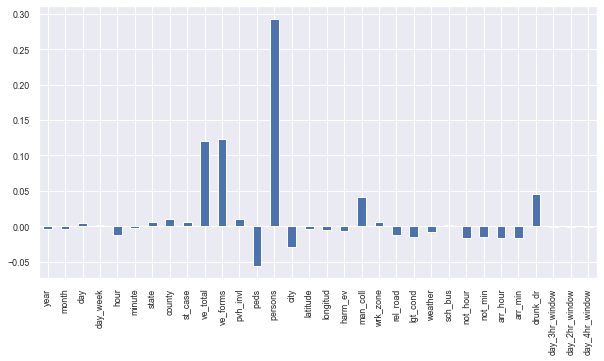

In [220]:

plt.figure(figsize=(10,5));
df_accident_ts.drop(columns="fatals").corrwith(df_accident_ts['fatals']).plot(kind='bar', sort_columns=True)

#### **Interpretation:**
Fatals is positively correlated to drunk_dr, persons, ve_total (same as ve_forms), maneuver to avoid collision, work_zone, and negatively correlated to peds, weather and light condition.   
We can use these for modeling. Since we're doing a Time series, we will only use:  
drunk_dr, persons, ve_total and peds along with fatals

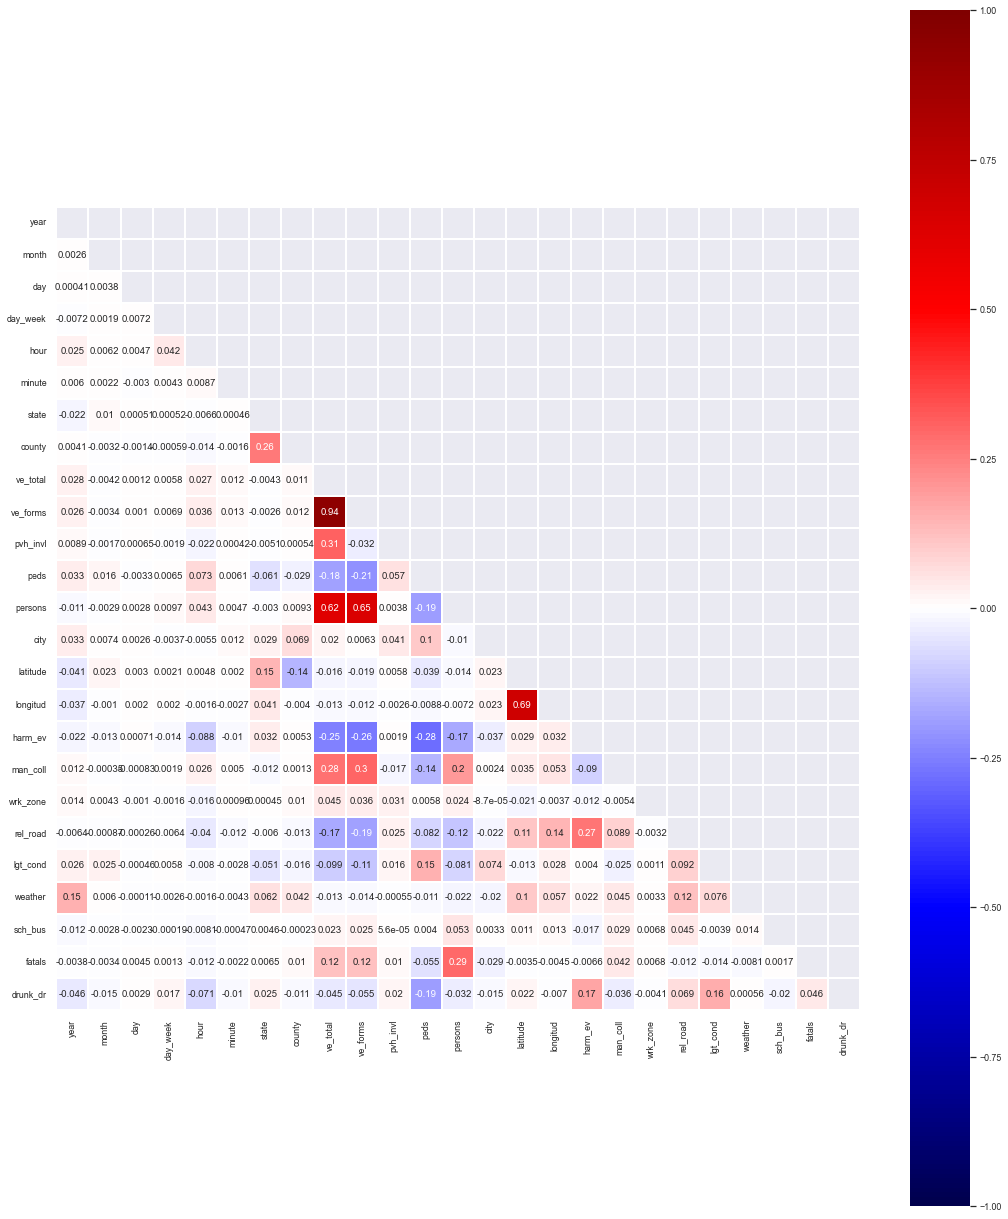

In [222]:
# heatmap showing correlation for relevant columns. 

corr = df_accident_ts.drop( columns=["day_3hr_window", "day_2hr_window", "day_4hr_window", "not_hour", "not_min", "arr_hour", "arr_min", "st_case"]).corr()
plt.figure(figsize=(18,22))

sns.set(font_scale=0.8)

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, cmap='seismic', annot=True, square=True,
            vmin = -1, vmax = 1, mask = mask,
            linecolor='white', linewidths=0.1);

#### **Interpretation:** 
Among AutoRregressive options like ARIMA, SARIMAX etc, I chose the Vector AutoRegressive (VAR) model since it is a bi-directional multivariate forecasting algorithm where two or more time series influence each other. In our case, the number of fatalities, alcohol-impaired drivers, pedestrians killed, vehicles and persons involved influence each other. Each of these variables is modeled as a linear combination of past values of itself (lags) and the past values of these other variables. 

Correlation confirmed that these influence each other and hence can use the VAR model to forecast all five variables. 


In [71]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    legend_list = []
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        legend_list.append(col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=12)
    
    plt.legend(legend_list);

In [232]:
# Our dataset is per accident and we converted it to a timeseries by day. 
# We will evaluate monthly, weekly, daily and 3hour window resampled timeseries. 
# Monthly has only 11*12 = 132 observations, weekly has 6864 and daily has 2505360. We wont need more data so will not spend much time on the 3hour modeling

# Create new df for modeling which has the columns we need, by month
df_model = df_accident_ts.resample("M").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

# Create new df for modeling which has the columns we need, by week
df_model_week = df_accident_ts.resample("W").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

# Create new df for modeling which has the columns we need, by day 
df_model_day = df_accident_ts.resample("D").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

# Create new df for modeling which has the columns we need, by 3 hour window

df_model_3hour = df_accident_ts.resample("3H").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]


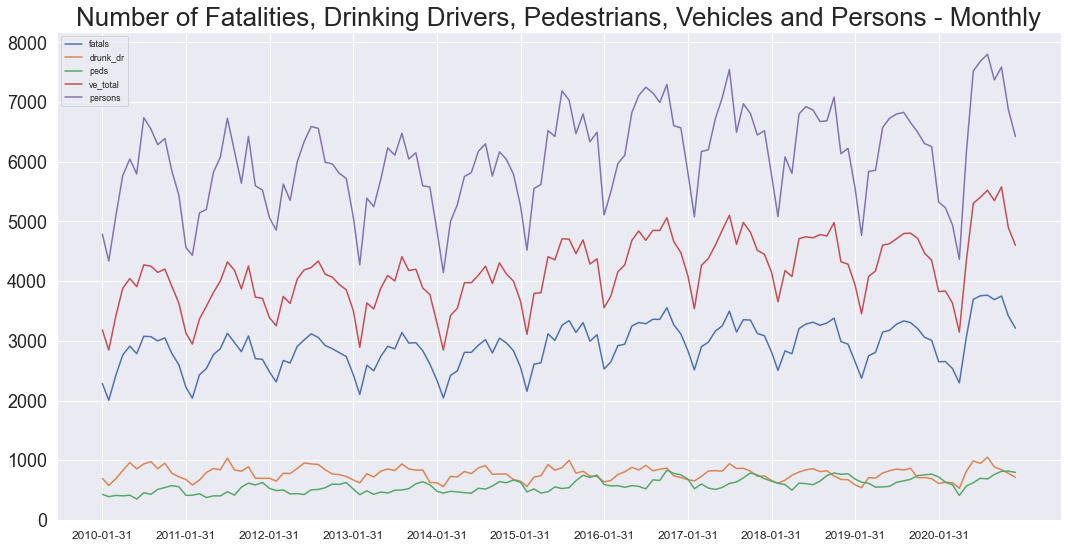

In [228]:
# 
plot_series(df_model, cols=["fatals", "drunk_dr", "peds", "ve_total", "persons" ], title="Number of Fatalities, Drinking Drivers, Pedestrians, Vehicles and Persons - Monthly", steps = 12)

#### **Interpretation:**
Notice the sharp drop during the initial Covid lockdown period of March-April 2020.   
The number of fatalities and drinking drivers along with all the other variables increased thereafter and soon exceeded the pre-Covid levels

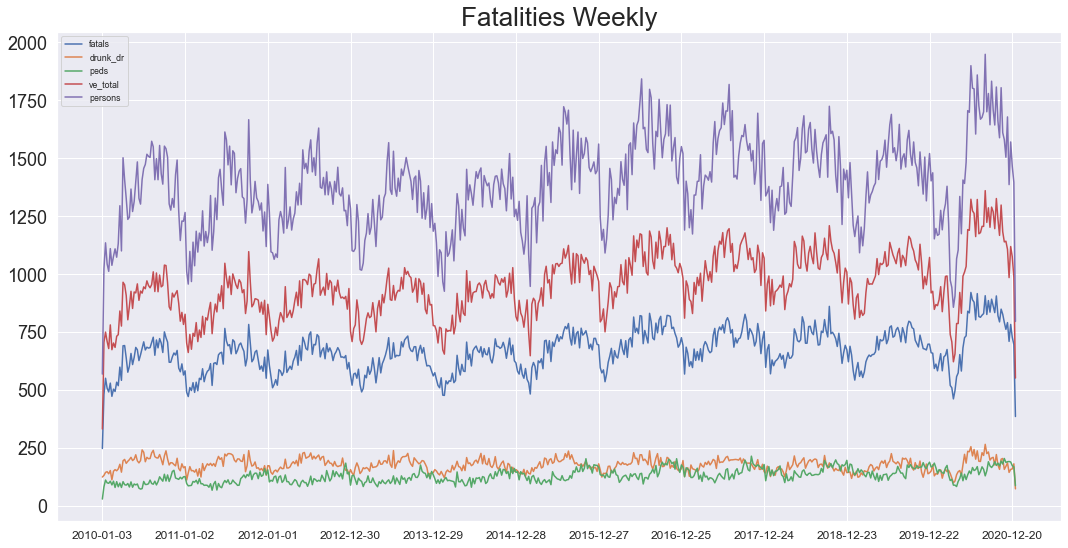

In [229]:
# 
plot_series(df_model_week, cols=["fatals", "drunk_dr", "peds", "ve_total", "persons" ], title="Fatalities Weekly", steps = 52)

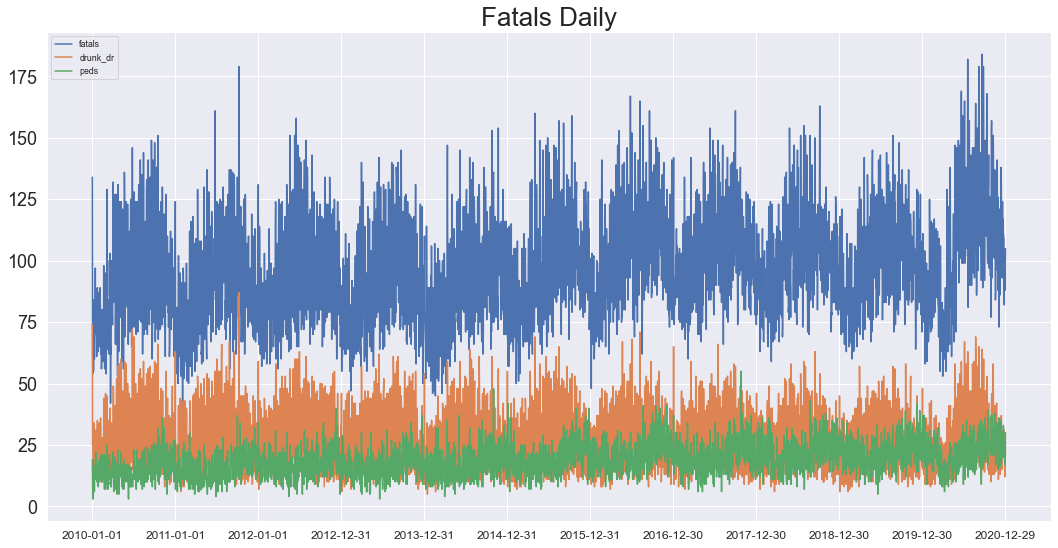

In [230]:
plot_series(df_model_day, cols=["fatals", "drunk_dr", "peds" ], title="Fatals Daily", steps = 365)


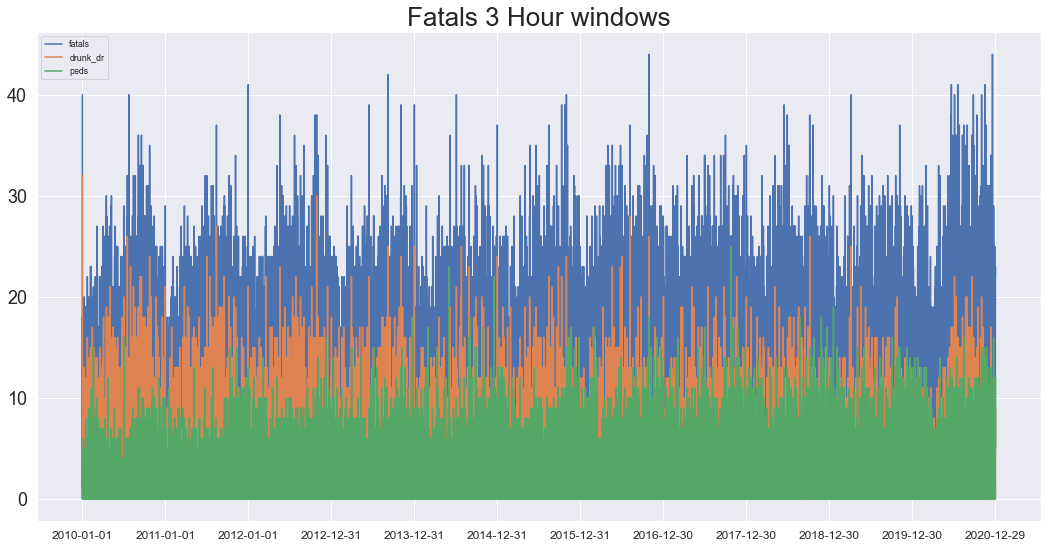

In [231]:
plot_series(df_model_3hour, cols=["fatals", "drunk_dr", "peds" ], title="Fatals 3 Hour windows", steps = 365*8)

#### **Interpretation:**
Note the steep variance in the 3 hour windows compared to the daily or other time periods. These reflect the weekend late night and holiday spikes. 

In [81]:
df_model_week.head()

,fatals,drunk_dr,peds,ve_total,persons
date_time,,,,,
2010-01-03,249,126,31,333,570
2010-01-10,482,133,84,707,1024
2010-01-17,552,146,113,751,1136
2010-01-24,509,149,101,711,1045
2010-01-31,493,140,99,680,1013


### We're using Vector AutoRegressive Time series for modeling. 
We need to confirm stationarity of the data. 

Do the ADF (Augmented Dickey Fuller) statistical Test to confirm stationarity of the time series variables. If needed, do a diff one or more times until stationarity is achieved. 

In [233]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [234]:
interpret_dftest(adfuller(df_model['fatals']))

Test Statistic    -0.319634
p-value            0.922677
Lag Used          12.000000
dtype: float64

In [235]:
interpret_dftest(adfuller(df_model['fatals'].diff().dropna())) # Yay, stationary!! 

Test Statistic    -5.490023
p-value            0.000002
Lag Used          11.000000
dtype: float64

In [236]:
# Create column.

df_model['first_diff_fatals'] = df_model['fatals'].diff()

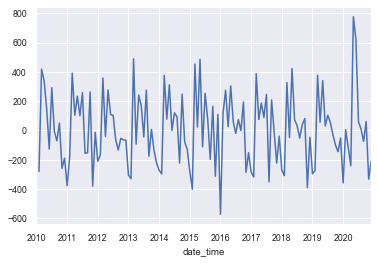

In [237]:
df_model['first_diff_fatals'].plot();

In [239]:
interpret_dftest(adfuller(df_model['drunk_dr'])) # next variable

Test Statistic    -1.994409
p-value            0.289030
Lag Used          12.000000
dtype: float64

In [240]:
interpret_dftest(adfuller(df_model['drunk_dr'].diff().dropna())) # Yay, stationary!! 

Test Statistic    -4.304375
p-value            0.000437
Lag Used          13.000000
dtype: float64

In [241]:
# Create column.

df_model['first_diff_drunk_dr'] = df_model['drunk_dr'].diff()

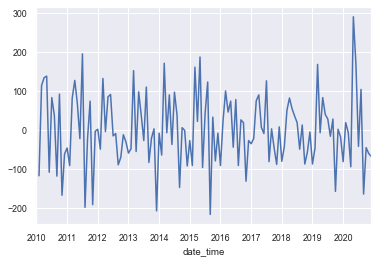

In [242]:
df_model['first_diff_drunk_dr'].plot();

In [243]:
interpret_dftest(adfuller(df_model['peds']))

Test Statistic    -0.816308
p-value            0.814285
Lag Used          11.000000
dtype: float64

In [244]:
interpret_dftest(adfuller(df_model['peds'].diff().dropna())) # Yay, stationary!! 

Test Statistic   -1.125372e+01
p-value           1.687178e-20
Lag Used          1.000000e+01
dtype: float64

In [245]:
# Create column.

df_model['first_diff_peds'] = df_model['peds'].diff()

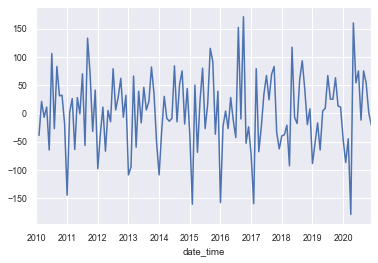

In [246]:
df_model['first_diff_peds'].plot();

In [247]:
df_model.head()

,fatals,drunk_dr,peds,ve_total,persons,first_diff_fatals,first_diff_drunk_dr,first_diff_peds
date_time,,,,,,,,
2010-01-31,2285,694,428,3182,4788,NaN,NaN,NaN
2010-02-28,2005,577,389,2846,4338,-280.0,-117.0,-39.0
2010-03-31,2424,691,410,3416,5091,419.0,114.0,21.0
2010-04-30,2764,825,403,3880,5769,340.0,134.0,-7.0
2010-05-31,2912,963,414,4045,6046,148.0,138.0,11.0


Use the coefficient of correlation between two values in a time series, the autocorrelation function (ACF), to identify seasonality in our time series data. 

Use the ACF plot, a bar chart of the coefficients of correlation between a time series and lags of itself, to pick the points that are statistically significant (outside the blue shaded Confidence Interval region). 

Use the Partial autocorrelation (PACF), a statistical measure that captures the correlation between two variables after controlling for the effects of other variables, to confirm the statistically significant lags.


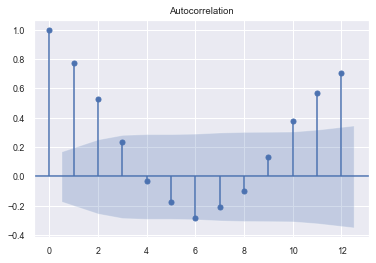

In [248]:

plot_acf( df_model['fatals'], lags=12); # blue shaded area is confidence interval. 
# If the datapoints are outside the CI, they are statistically significant and can be used in the model

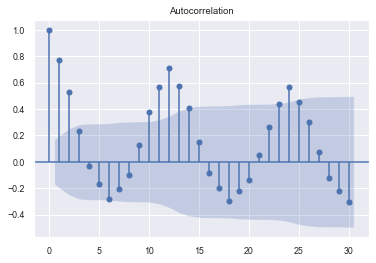

In [249]:
plot_acf( df_model['fatals'], lags=30); 


#### **Interpretation** : 
Notice how the coefficient is high at lags 12, 24 (which is a one year interval in our monthly timeseries).  
We will focus on the points that lie beyond the blue region as they signify strong statistical significance.


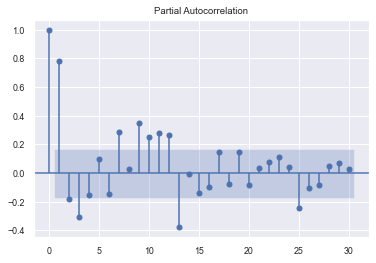

In [250]:
# Generate the PACF plot 

plot_pacf( df_model['fatals'], lags=30); # blue shaed area is confidence interval. If the datapoints are outside the CI, they are statitically significant and can be usedin the model


#### **Interpretation** : 
Datapoints outside the Confidence Interval (blue shaded area) can be used in the model.  
Notice the spikes at lags 12 and 24

#### Not that we have confirmed stationarity, it's time to decompose the three parts of a time series – the trend, seasonality and residuals for all 5 variables.   

We will do this for all our models - monthly, weekly and daily and for all the variables


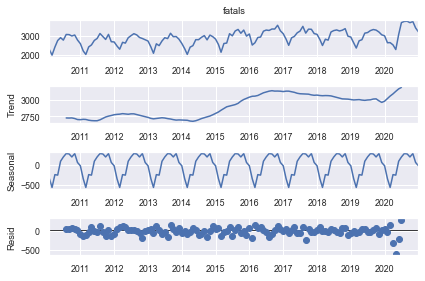

In [251]:
decomp = seasonal_decompose(df_model['fatals'])
decomp.plot();


#### **Interpretation** : 

Seasonal Decomposition of Fatals. Nice seasonality - summer months have higher fatalities, Jan-Feb is the dip. Number of miles driven is 10-20% lower in these 2 winter months as compared to the summer (external research)


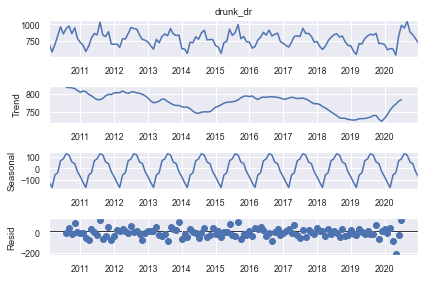

In [252]:
decomp = seasonal_decompose(df_model['drunk_dr'])
decomp.plot();


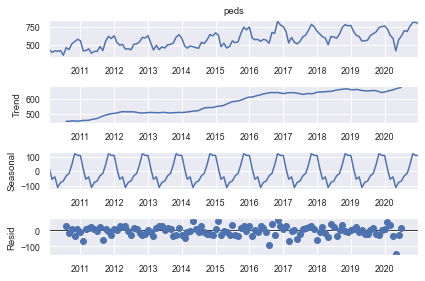

In [254]:
decomp = seasonal_decompose(df_model['peds'])
decomp.plot();


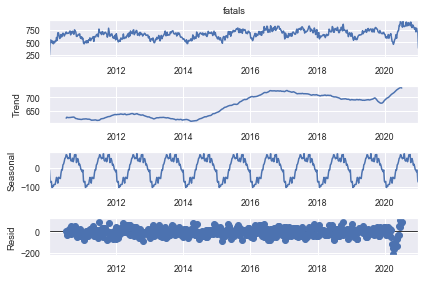

In [258]:
# now weekly
decomp = seasonal_decompose(df_model_week['fatals'])
decomp.plot();



#### **Interpretation** : 

Seasonal Decomposition of Fatals. Nice seasonality - summer months have higher fatalities, Jan-Feb is the dip. Number of miles driven is 10-20% lower in these 2 winter months as compared to the summer. 


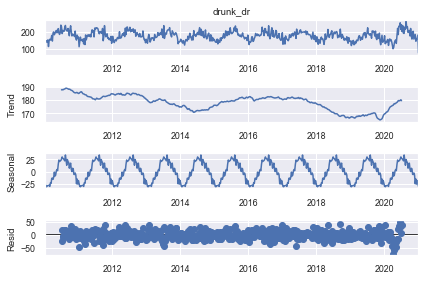

In [259]:
decomp = seasonal_decompose(df_model_week['drunk_dr'])
decomp.plot();


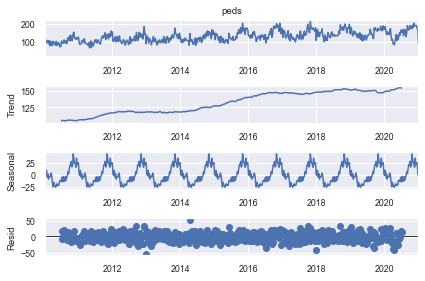

In [260]:
decomp = seasonal_decompose(df_model_week['peds'])
decomp.plot();


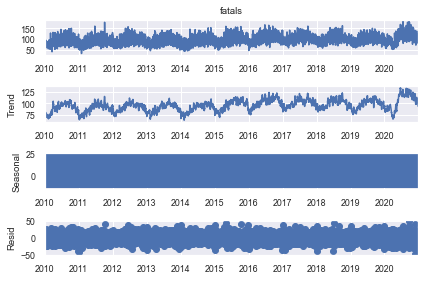

In [262]:
# now daily
decomp = seasonal_decompose(df_model_day['fatals'])
decomp.plot();

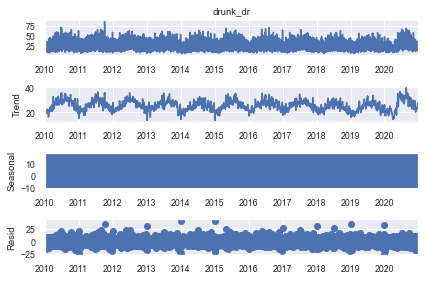

In [263]:
decomp = seasonal_decompose(df_model_day['drunk_dr'])
decomp.plot();

### We've completed the ADF tests and seasonal decomposition.  
We're good to begin modeling now!

In [108]:
df_model.head()

,fatals,drunk_dr,peds,ve_total,persons,first_diff_fatals,first_diff_drunk_dr,first_diff_peds
date_time,,,,,,,,
2010-01-31,2285,694,428,3182,4788,NaN,NaN,NaN
2010-02-28,2005,577,389,2846,4338,-280.0,-117.0,-39.0
2010-03-31,2424,691,410,3416,5091,419.0,114.0,21.0
2010-04-30,2764,825,403,3880,5769,340.0,134.0,-7.0
2010-05-31,2912,963,414,4045,6046,148.0,138.0,11.0


In [264]:
# Subset our data. Use our differenced columns
df_ts = df_model[['first_diff_fatals', 'first_diff_drunk_dr', 'first_diff_peds']]

# Let's get rid of rows containing missing values.
df_ts.dropna(inplace = True)

df_ts


/var/folders/06/2ml34kbd5jbg6988jmpwrgz00r_kcc/T/ipykernel_14921/565716649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts.dropna(inplace = True)


,first_diff_fatals,first_diff_drunk_dr,first_diff_peds
date_time,,,
2010-02-28,-280.0,-117.0,-39.0
2010-03-31,419.0,114.0,21.0
2010-04-30,340.0,134.0,-7.0
2010-05-31,148.0,138.0,11.0
2010-06-30,-127.0,-108.0,-65.0
...,...,...,...
2020-08-31,10.0,104.0,-12.0
2020-09-30,-75.0,-164.0,75.0
2020-10-31,61.0,-45.0,54.0


### Train test Split

In [269]:
train, test = train_test_split(df_ts, shuffle=False, 
                               test_size = 0.05) # use small test size, as we can't predict far into the future
# Out of 131 rows (dropped one null), train has 124 and test has 7

In [270]:
# Instantiate a VAR model. 

model = VAR(train, dates = train.index, freq='M')

In [271]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2020-06-30 to 2020-12-31
Freq: M
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_diff_fatals    7 non-null      float64
 1   first_diff_drunk_dr  7 non-null      float64
 2   first_diff_peds      7 non-null      float64
dtypes: float64(3)
memory usage: 224.0 bytes


In [114]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit( maxlags=15, # what is the largest possible value of p?
                     ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [273]:

# What is the order of our autoregressive model? 
# Order ‘p’ means, up to p-lags of Y are used and they are the predictors in the equation
ts_model.k_ar

13

In [274]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Apr, 2022
Time:                     01:11:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    27.3173
Nobs:                     111.000    HQIC:                   25.5763
Log likelihood:          -1706.04    FPE:                4.32248e+10
AIC:                      24.3880    Det(Omega_mle):     1.71700e+10
--------------------------------------------------------------------
Results for equation first_diff_fatals
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -6.796099        15.614924           -0.435           0.663
L1.first_diff_fatals           -0.492131         0.195209           -2.521           0.012
L1.first

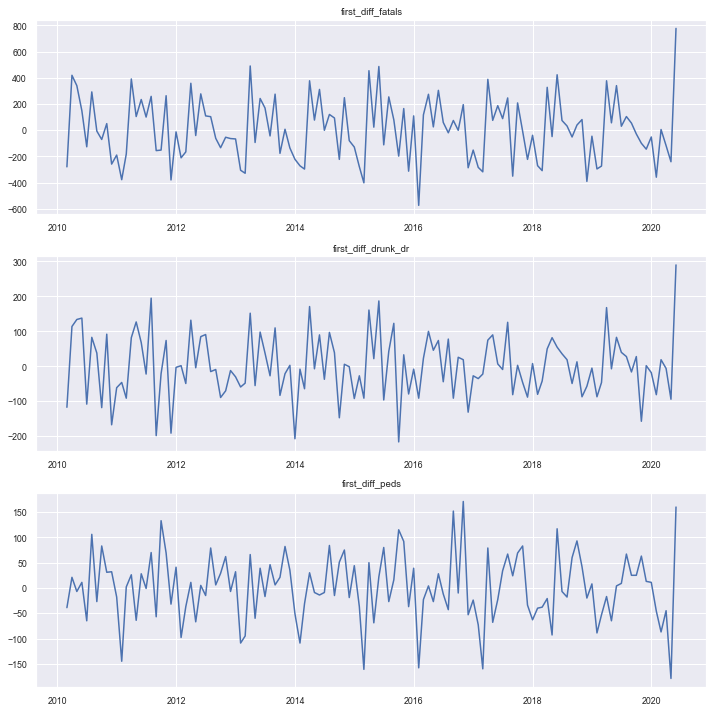

In [275]:
# Plot our training data.
ts_model.plot();
plt.tight_layout()

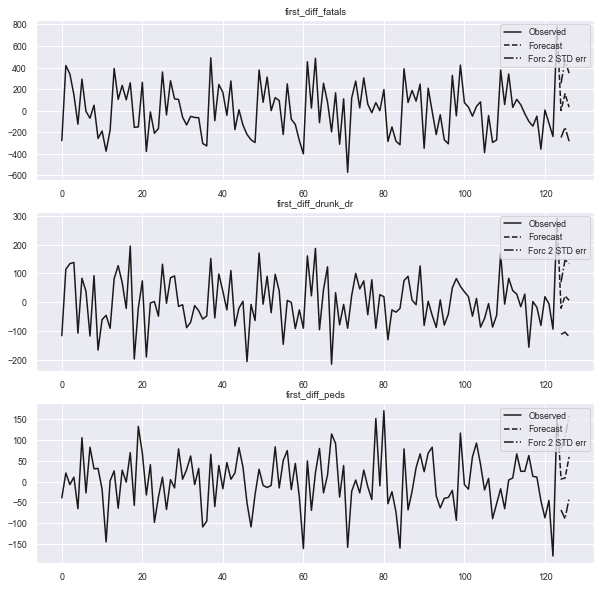

In [276]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);


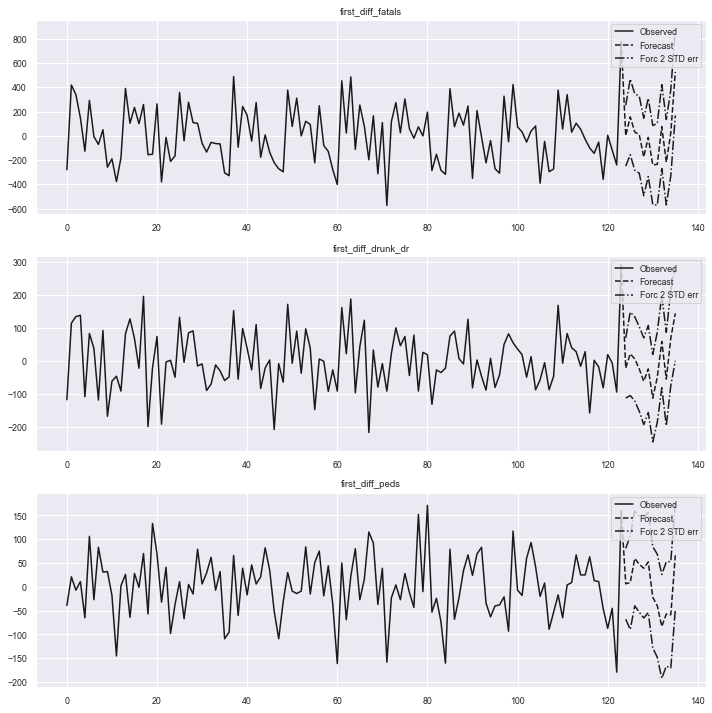

In [277]:
# Plot the forecast looking 12 steps ahead.

ts_model.plot_forecast(12);
plt.tight_layout()

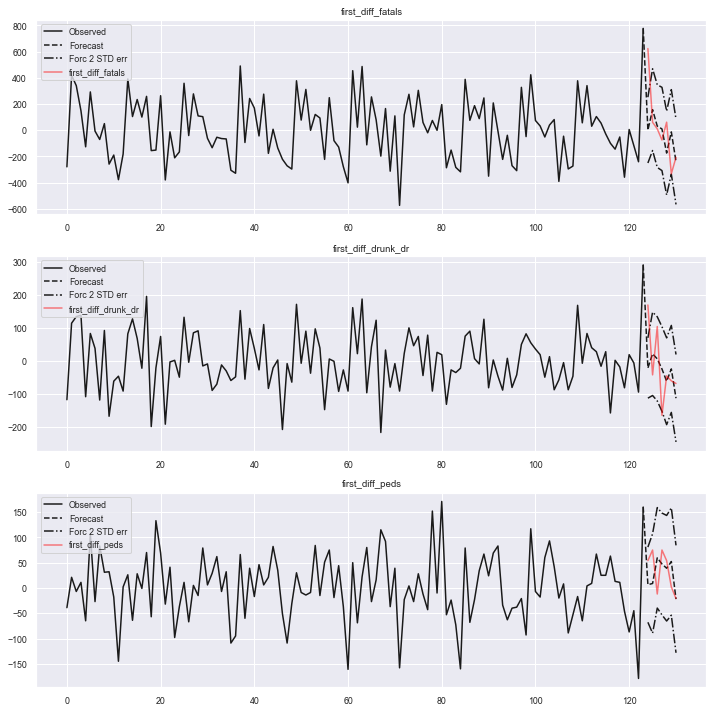

In [279]:
#Plot the forecast for the whole test set (and overlay the actual test values)
model_axes = ts_model.plot_forecast(test.shape[0]);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train)
     plot_df.plot(ax = ax, label = test.columns[i], color = 'red', alpha = 0.5)
     # zoom in 
     #plt.xlim(plot_df.index[-6], plot_df.index[-1])
     #plt.xlim(y_train.index[-15], y_test.index[-1])
     
     ax.legend(loc=2) # upper left
plt.tight_layout();

In [280]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, len(test))[:10]

array([[   0.74874254,  -21.2657364 ,    6.41383678],
       [ 156.50045557,   21.59521995,    8.83007726],
       [  31.06036598,    6.33530024,   59.54572162],
       [   9.37833608,  -24.21251201,   47.44047008],
       [-174.82586624,  -61.29119772,   38.97049679],
       [ -13.17915805,  -23.99740568,   52.2032994 ],
       [-240.9954705 , -112.45493851,  -21.99908366]])

In [281]:
# see values of test
test

,first_diff_fatals,first_diff_drunk_dr,first_diff_peds
date_time,,,
2020-06-30,623.0,169.0,54.0
2020-07-31,60.0,-42.0,75.0
2020-08-31,10.0,104.0,-12.0
2020-09-30,-75.0,-164.0,75.0
2020-10-31,61.0,-45.0,54.0
2020-11-30,-333.0,-60.0,2.0
2020-12-31,-207.0,-68.0,-21.0


#### 6. Evaluate model (and forecasts, if possible).

In [282]:
# We'll use RMSE

# Save forecasted values
forecast = ts_model.forecast(train.values, len(test))

# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test.values[:, i], y_pred=forecast[:, i]), 4)}')


The test RMSE on the first_diff_fatals data is: 283.6313
The test RMSE on the first_diff_drunk_dr data is: 102.0239
The test RMSE on the first_diff_peds data is: 46.7034


#### Since we were forecasting differenced values, we want to undifference our data, that way we can compare the forecasts to the real (undifferenced) values

In [284]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model.forecast(train.values, len(test)),
                           columns = test.columns, index = test.index)


In [285]:

## Then we can undifference our once-differenced columns
### We do this by taking the last value from the original column before our test data
### and adding the cumulative summed first differenced forecasts
forecast_df['forecast_fatals'] = df_model['fatals'].iloc[-len(test)-1]  + forecast_df['first_diff_fatals'].cumsum()
forecast_df['forecast_drunk_dr'] = df_model['drunk_dr'].iloc[-len(test)-1]  + forecast_df['first_diff_drunk_dr'].cumsum()
forecast_df['forecast_peds'] = df_model['peds'].iloc[-len(test)-1]  + forecast_df['first_diff_peds'].cumsum()


In [286]:
## Check out dataframe to see undifferenced forecasts
forecast_df.head()

,first_diff_fatals,first_diff_drunk_dr,first_diff_peds,forecast_fatals,forecast_drunk_dr,forecast_peds
date_time,,,,,,
2020-06-30,0.748743,-21.265736,6.413837,3072.748743,797.734264,575.413837
2020-07-31,156.500456,21.595220,8.830077,3229.249198,819.329484,584.243914
2020-08-31,31.060366,6.335300,59.545722,3260.309564,825.664784,643.789636
2020-09-30,9.378336,-24.212512,47.440470,3269.687900,801.452272,691.230106
2020-10-31,-174.825866,-61.291198,38.970497,3094.862034,740.161074,730.200603


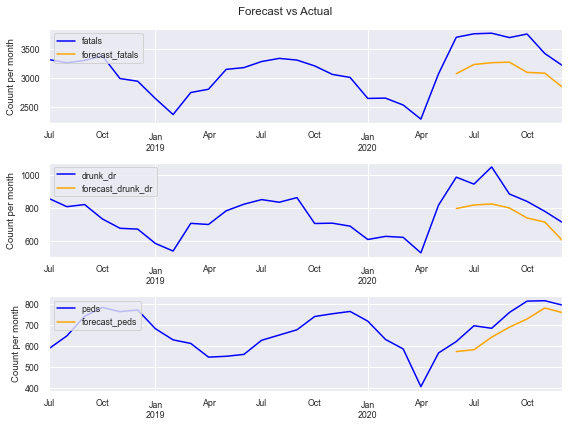

In [287]:
## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,6))

for i, ax in enumerate([ax1,ax2,ax3]):
    df_model.loc[df_model.index[-30:]][df_model.columns[i]].plot(ax = ax, legend = True, color = 'blue') # show ony last 30 months
    #df_model[df_model.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[f"forecast_{df_model.columns[i]}"].plot(ax = ax, legend = True, color = 'orange')
    ax.legend(loc=2) # upper left to avoid overlap with the graph
    ax.set_xlabel("")
    ax.set_ylabel("Couunt per month")

plt.suptitle( "Forecast vs Actual")
plt.tight_layout()


#### **Interpretation** : 
The forecast does a pretty good job in following the actual curve except where the data spikes suddenly. 


In [288]:
# We will use RMSE and MAPE (Mean Absolute Percent Error) as our evaluation metrics

#Loop through columns and get RMSE and MAPE for each
for i,col in enumerate(df_model.columns[:3]):
    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i],forecast_df.loc[:, f"forecast_{col}"], squared = False), 4)}')
    print(f'The test MAPE on the {col} data is: {round(mean_absolute_percentage_error(df_model.iloc[-len(test):, i], forecast_df.loc[:, f"forecast_{col}"]), 4)}')
    

The test RMSE on the fatals data is: 503.6641
The test MAPE on the fatals data is: 0.135
The test RMSE on the drunk_dr data is: 139.4058
The test MAPE on the drunk_dr data is: 0.1417
The test RMSE on the peds data is: 67.0919
The test MAPE on the peds data is: 0.0834


In [289]:
# Calculate baseline_RMSE and MAPE to evaluate performance of model against the baseline
y_test_baseline_df = pd.DataFrame()

for i,col in enumerate(df_model.columns[:3]):
    y_test_baseline_df[col] = [df_model.iloc[:len(train)+1, i].mean()] * len(test)    
    print(f'The baseline RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i], y_test_baseline_df[col], squared = False), 4)}')
    
    print(f'The baseline MAPE on the {col} data is: {round(mean_absolute_percentage_error(df_model.iloc[-len(test):, i], y_test_baseline_df[col]), 4)}')



The baseline RMSE on the fatals data is: 761.9811
The baseline MAPE on the fatals data is: 0.2011
The baseline RMSE on the drunk_dr data is: 158.5058
The baseline MAPE on the drunk_dr data is: 0.1391
The baseline RMSE on the peds data is: 190.0377
The baseline MAPE on the peds data is: 0.2315


### We're done with the monthly VAR!  
Now try with the weekly data to see if the model performance improves with more data

In [290]:
interpret_dftest(adfuller(df_model_week['fatals']))

Test Statistic    -5.588035
p-value            0.000001
Lag Used          13.000000
dtype: float64

In [293]:
# Stationary, p < 0.05. So we don't need diff column
#df_model_week['first_diff_fatals'] = df_model_week['fatals'].diff()

In [294]:
interpret_dftest(adfuller(df_model_week['drunk_dr']))

Test Statistic   -8.852083e+00
p-value           1.563072e-14
Lag Used          1.800000e+01
dtype: float64

In [295]:
#Stationary, don't need diff column
#df_model_week['first_diff_drunk_dr'] = df_model_week['drunk_dr'].diff()

In [296]:
interpret_dftest(adfuller(df_model_week['peds']))


Test Statistic   -3.644284
p-value           0.004969
Lag Used          4.000000
dtype: float64

In [297]:
# Stationary, dont need diff column
#df_model_week['first_diff_peds'] = df_model_week['peds'].diff()

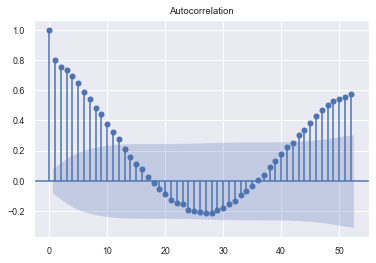

In [298]:
# 52 weekly lags
plot_acf( df_model_week['fatals'], lags=52); # blue shaded area is confidence interval. 
# If the datapoints are outside the CI, they are statistically significant and can be used in the model


#### **Interpreation** : 
Nice trend! 
Datapoints outside the Confidence Interval (blue shaded area) can be used in the model

### Model Weekly - Train test Split
Let's try a couple of different things:   
- Try 5 Y variables (instead of the 3 we used above)
- Since we have 4 times more data more data compared to the monthly model, let's take a 10% test size split. 517 and 58.

In [301]:
df_model_week.head() # dont have any diff columns, since they aren't needed

,fatals,drunk_dr,peds,ve_total,persons
date_time,,,,,
2010-01-03,249,126,31,333,570
2010-01-10,482,133,84,707,1024
2010-01-17,552,146,113,751,1136
2010-01-24,509,149,101,711,1045
2010-01-31,493,140,99,680,1013


In [302]:

# Don't need to Subset our data. Take all 5 columns too, not sure if this impacts model performance 

#df_ts = df_model_week[['first_diff_fatals', 'first_diff_drunk_dr', 'first_diff_peds']]

# Let's get rid of rows containing missing values.
df_model_week.dropna(inplace = True)

In [303]:
train_w, test_w = train_test_split(df_model_week, shuffle=False, 
                               test_size = 0.10) # take only 10% for test

In [304]:
# Instantiate a VAR model. 

model_w = VAR(train_w, dates = train_w.index, freq='W')

In [305]:
# Fit our model and use AIC to select the value of p.

ts_model_w = model_w.fit( maxlags=52, # what is the largest possible value of p?
                     ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [306]:
# What is the order of our autoregressive model? 
ts_model_w.k_ar

5

In [310]:
train_w.info

<bound method DataFrame.info of             fatals  drunk_dr  peds  ve_total  persons
date_time                                            
2010-01-03     249       126    31       333      570
2010-01-10     482       133    84       707     1024
2010-01-17     552       146   113       751     1136
2010-01-24     509       149   101       711     1045
2010-01-31     493       140    99       680     1013
...            ...       ...   ...       ...      ...
2019-10-27     702       166   176      1047     1459
2019-11-03     687       163   166      1019     1382
2019-11-10     738       195   169      1130     1528
2019-11-17     710       146   169      1049     1439
2019-11-24     680       125   188       938     1346

[517 rows x 5 columns]>

In [307]:
test_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2019-12-01 to 2021-01-03
Freq: W-SUN
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   fatals    58 non-null     int64
 1   drunk_dr  58 non-null     int64
 2   peds      58 non-null     int64
 3   ve_total  58 non-null     int64
 4   persons   58 non-null     int64
dtypes: int64(5)
memory usage: 2.7 KB


In [311]:
# Check out the summary of our model!
ts_model_w.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Apr, 2022
Time:                     01:29:18
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    33.1676
Nobs:                     512.000    HQIC:                   32.5133
Log likelihood:          -11717.9    FPE:                8.65604e+13
AIC:                      32.0914    Det(Omega_mle):     6.75706e+13
--------------------------------------------------------------------
Results for equation fatals
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             107.894767        22.665809            4.760           0.000
L1.fatals           0.456880         0.128109            3.566           0.000
L1.drunk_dr        -0.022980         0.140712           -0.163     

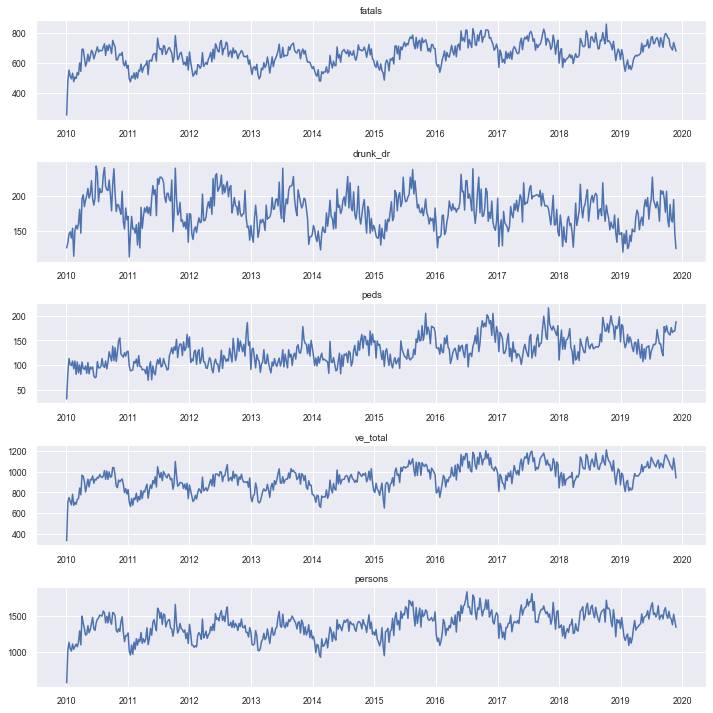

In [312]:
# Plot our training data.
ts_model_w.plot();
plt.tight_layout()

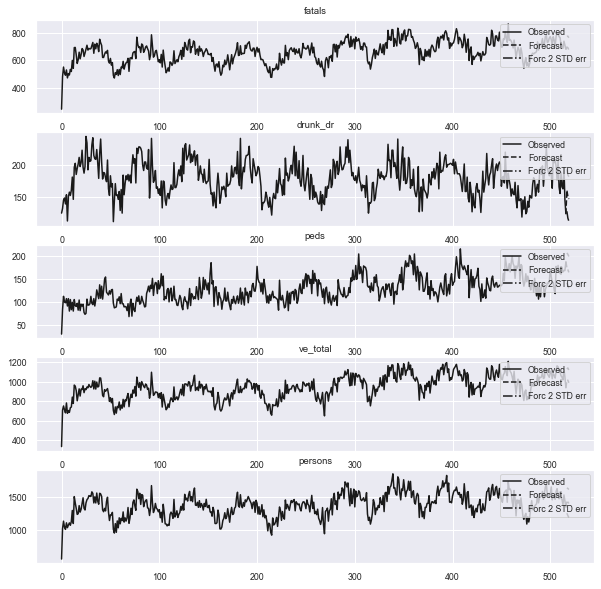

In [313]:
# Plot the forecast looking 3 steps ahead.
ts_model_w.plot_forecast(3);

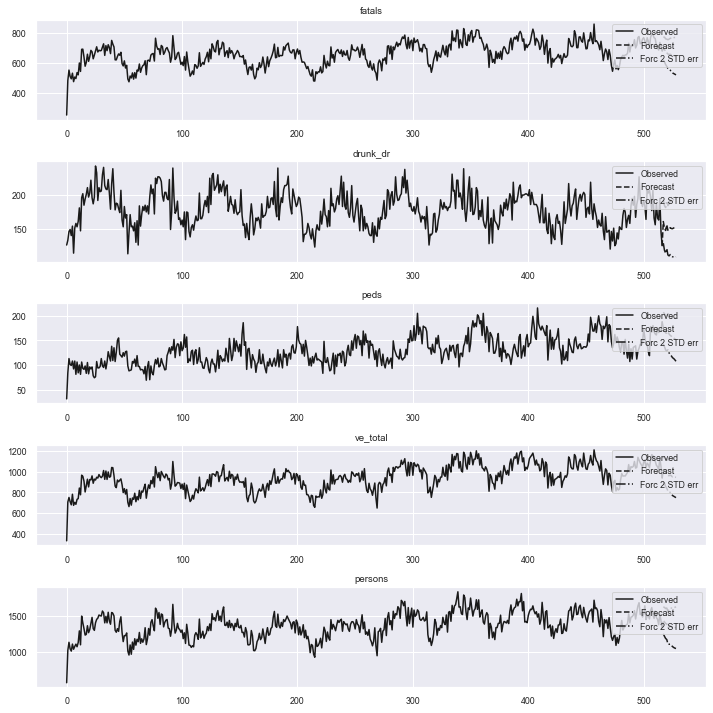

In [314]:
# Plot the forecast looking 12 steps ahead.

ts_model_w.plot_forecast(12);
plt.tight_layout()

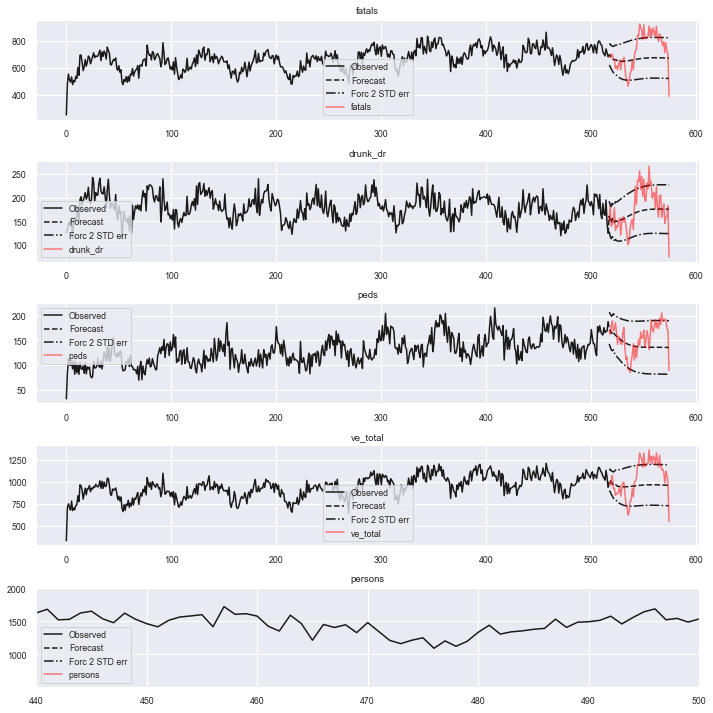

In [315]:
#Plot the forecast for the whole test set (& overlay the actual test values)
model_axes = ts_model_w.plot_forecast(test_w.shape[0]);

plt.xlim(440,500);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test_w.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train_w)
     plot_df.plot(ax = ax, label = test_w.columns[i], color = 'red', alpha = 0.5)
     ax.legend()
     #ax.xlim(400,500)

plt.tight_layout();


#### **Interpretation:** 
The weekly graphs don't look as good as the monthly one

In [317]:
# Generate a forecast that matches our testing set.
ts_model_w.forecast(train_w.values, len(test_w))[:10]

array([[ 695.73194814,  160.77561811,  174.86261586, 1015.00227641,
        1443.89343356],
       [ 691.03443514,  151.47617815,  170.75836506, 1015.96565625,
        1422.2297111 ],
       [ 676.07682717,  147.58398549,  165.06726445,  989.1314885 ,
        1399.1943349 ],
       [ 668.81902963,  155.93344495,  164.6070436 ,  979.641931  ,
        1395.19895283],
       [ 659.7255991 ,  147.79238213,  167.70154579,  962.59962708,
        1341.38647463],
       [ 657.8296479 ,  148.42737733,  162.98804737,  960.92004789,
        1350.87212943],
       [ 658.58402094,  151.7034386 ,  160.23113664,  966.56292289,
        1362.66463353],
       [ 655.36173651,  150.40413521,  158.46294361,  959.84445757,
        1354.2183535 ],
       [ 649.50272177,  150.19012404,  155.74841321,  948.38965955,
        1345.31649107],
       [ 649.05330083,  151.28763989,  154.92386519,  948.41497326,
        1340.74943376]])

In [318]:
# see values of test
test_w.values[:10]

array([[ 678,  152,  170,  991, 1506],
       [ 674,  182,  162,  955, 1317],
       [ 699,  140,  180, 1012, 1434],
       [ 699,  144,  190, 1073, 1521],
       [ 662,  152,  169,  920, 1403],
       [ 660,  179,  173,  927, 1438],
       [ 594,  131,  186,  849, 1153],
       [ 613,  141,  166,  870, 1198],
       [ 584,  138,  142,  865, 1168],
       [ 622,  152,  158,  891, 1173]])

#### 6. Evaluate model (and forecasts, if possible).

#### No undiff required. Do Forecast


In [320]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model_w.forecast(test_w.values, len(test_w)),
                           columns = test_w.columns, index = test_w.index)
                           
forecast_df.head()

,fatals,drunk_dr,peds,ve_total,persons
date_time,,,,,
2019-12-01,584.040262,145.241978,160.364211,832.518580,1145.000663
2019-12-08,607.190138,147.872016,155.734727,871.242633,1209.965140
2019-12-15,564.772368,128.699136,146.897803,841.672893,1145.696817
2019-12-22,578.609589,142.459886,137.357342,843.329733,1208.162277
2019-12-29,572.127343,144.330575,129.835991,825.551655,1189.466369


In [321]:
## Check out dataframe to see undifferenced forecasts
forecast_df.head()

,fatals,drunk_dr,peds,ve_total,persons
date_time,,,,,
2019-12-01,584.040262,145.241978,160.364211,832.518580,1145.000663
2019-12-08,607.190138,147.872016,155.734727,871.242633,1209.965140
2019-12-15,564.772368,128.699136,146.897803,841.672893,1145.696817
2019-12-22,578.609589,142.459886,137.357342,843.329733,1208.162277
2019-12-29,572.127343,144.330575,129.835991,825.551655,1189.466369


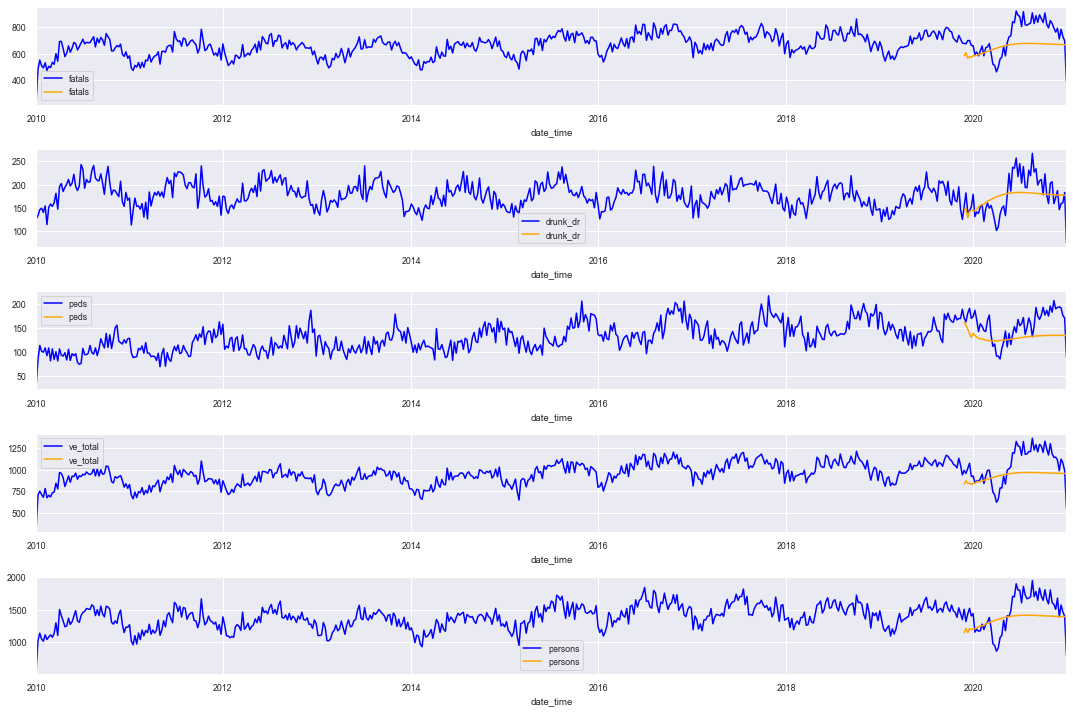

In [325]:
## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize = (15,10))

for i, ax in enumerate([ax1,ax2,ax3, ax4, ax5]):
    df_model_week[df_model_week.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[{df_model_week.columns[i]}].plot(ax = ax, legend = True, color = 'orange')
    
plt.tight_layout()

In [326]:
# Calculate all metrics in one place

# Save forecasted values
forecast = ts_model_w.forecast(test_w.values, len(test_w))
train_forecast = ts_model_w.forecast(train_w.values, len(train_w))

forecast_df = pd.DataFrame(data = ts_model_w.forecast(test_w.values, len(test_w)),
                           columns = test_w.columns, index = test_w.index)

# Loop through columns and get MSE for each
for i in range(test_w.shape[1]):
    print(f'The test MSE on the {test_w.columns[i]} data is: {round(mean_squared_error(test_w.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test_w.shape[1]):
    print(f'The test RMSE on the {test_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_w.values[:, i], y_pred=forecast[:, i]), 4)}')

#for i,col in enumerate(df_model_w.columns[:5]):
#    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i],forecast_df.loc[:, f"forecast_{col}"], squared = False), 4)}')


# Training RMSE
for i in range(train_w.shape[1]):
    print(f'The training RMSE on the {train_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=train_w.values[:, i], y_pred=train_forecast[:, i]), 4)}')

#baseline_RMSE
y_test_baseline_df = pd.DataFrame()

for i in range(test_w.shape[1]):
    y_test_baseline_df[train_w.columns[i]] = [train_w.values[:, i].mean()] * len(test_w)    
    print(f'The baseline RMSE on the {test_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_w.values[:, i], y_pred=y_test_baseline_df[train_w.columns[i]]), 4)}')


The test MSE on the fatals data is: 18678.1868
The test MSE on the drunk_dr data is: 1367.7701
The test MSE on the peds data is: 1351.0534
The test MSE on the ve_total data is: 45001.6524
The test MSE on the persons data is: 77967.5817
The test RMSE on the fatals data is: 136.6682
The test RMSE on the drunk_dr data is: 36.9834
The test RMSE on the peds data is: 36.7567
The test RMSE on the ve_total data is: 212.1359
The test RMSE on the persons data is: 279.2268
The training RMSE on the fatals data is: 79.9684
The training RMSE on the drunk_dr data is: 25.9543
The training RMSE on the peds data is: 30.3973
The training RMSE on the ve_total data is: 123.9348
The training RMSE on the persons data is: 175.2862
The baseline RMSE on the fatals data is: 142.8255
The baseline RMSE on the drunk_dr data is: 41.4593
The baseline RMSE on the peds data is: 40.0053
The baseline RMSE on the ve_total data is: 221.1654
The baseline RMSE on the persons data is: 292.9565


We'll use these metrics for model comparison and evaluation in a bit

### We're done with weekly. Now try daily data; and go back to only 3 cols, not the 5 that we used for weekly

In [327]:
interpret_dftest(adfuller(df_model_day['fatals'])) #stationary 

Test Statistic    -3.970957
p-value            0.001570
Lag Used          29.000000
dtype: float64

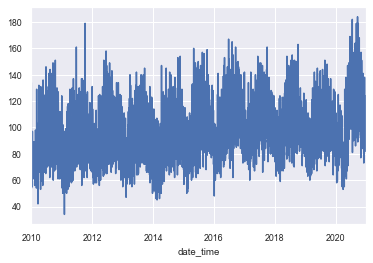

In [328]:
df_model_day['fatals'].plot();

In [329]:
interpret_dftest(adfuller(df_model_day['drunk_dr'])) #stationary        

Test Statistic    -4.812332
p-value            0.000052
Lag Used          29.000000
dtype: float64

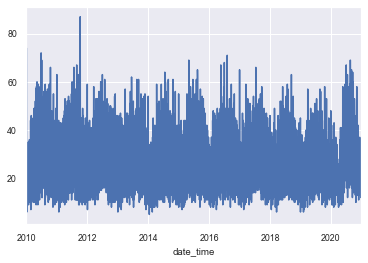

In [330]:
df_model_day['drunk_dr'].plot();

In [331]:
interpret_dftest(adfuller(df_model_day['peds'])) # stationary

Test Statistic    -3.696793
p-value            0.004158
Lag Used          29.000000
dtype: float64

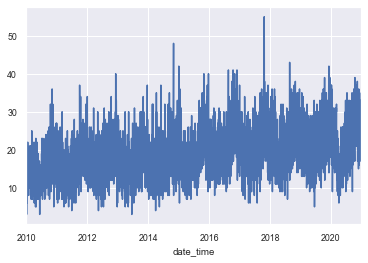

In [332]:
df_model_day['peds'].plot();

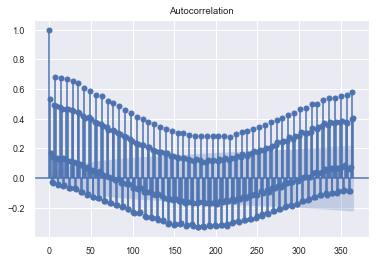

In [333]:
# One year trends

plot_acf( df_model_day['fatals'], lags=365); # blue shaed area is confidence interval. 
# If the datapoints are outside the CI, they are statistically significant and can be used in the model


#### **Interpreation** : 
Nice trend! 
Datapoints outside the Confidence Interval (blue shaded area) can be used in the model

### Model Daily - Train test Split

In [334]:
df_model_day.info() # dont have any diff columns, since they aren't needed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2010-01-01 to 2020-12-31
Freq: D
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   fatals    4018 non-null   int64
 1   drunk_dr  4018 non-null   int64
 2   peds      4018 non-null   int64
 3   ve_total  4018 non-null   int64
 4   persons   4018 non-null   int64
dtypes: int64(5)
memory usage: 188.3 KB


In [352]:

# Don't need to Subset our data. Take all 5 columns too, not sure if this impacts model performance 

#df_ts = df_model_week[['first_diff_fatals', 'first_diff_drunk_dr', 'first_diff_peds']]


df_model_day.drop(columns=["ve_total","persons"], inplace = True)

# Let's get rid of rows containing missing values.
df_model_day.dropna(inplace = True)

In [354]:
train_d, test_d = train_test_split(df_model_day, shuffle=False, 
                               test_size = 0.1) # take only 10% for test

# Train: 3616, Test: 402

In [355]:
train_d

,fatals,drunk_dr,peds
date_time,,,
2010-01-01,134,74,19
2010-01-02,61,25,9
2010-01-03,54,27,3
2010-01-04,70,13,9
2010-01-05,68,12,19
...,...,...,...
2019-11-21,88,10,33
2019-11-22,105,19,28
2019-11-23,120,29,30


In [356]:
# Instantiate a VAR model. 

model_d = VAR(train_d, dates = train_d.index, freq='D')

In [357]:
# Fit our model and use AIC to select the value of p.

ts_model_d = model_d.fit( maxlags=30, # what is the largest possible value of p?
                     ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [358]:
# What is the order of our autoregressive model? 
ts_model_d.k_ar

28

In [359]:
# Check out the summary of our model!
ts_model_d.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Apr, 2022
Time:                     01:44:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.0041
Nobs:                     3588.00    HQIC:                   11.7212
Log likelihood:          -35765.2    FPE:                    105299.
AIC:                      11.5645    Det(Omega_mle):         98156.9
--------------------------------------------------------------------
Results for equation fatals
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               13.106419         2.487415            5.269           0.000
L1.fatals            0.216513         0.022984            9.420           0.000
L1.drunk_dr         -0.064867         0.039580           -1.639

In [360]:
ts_model_d.names

['fatals', 'drunk_dr', 'peds']

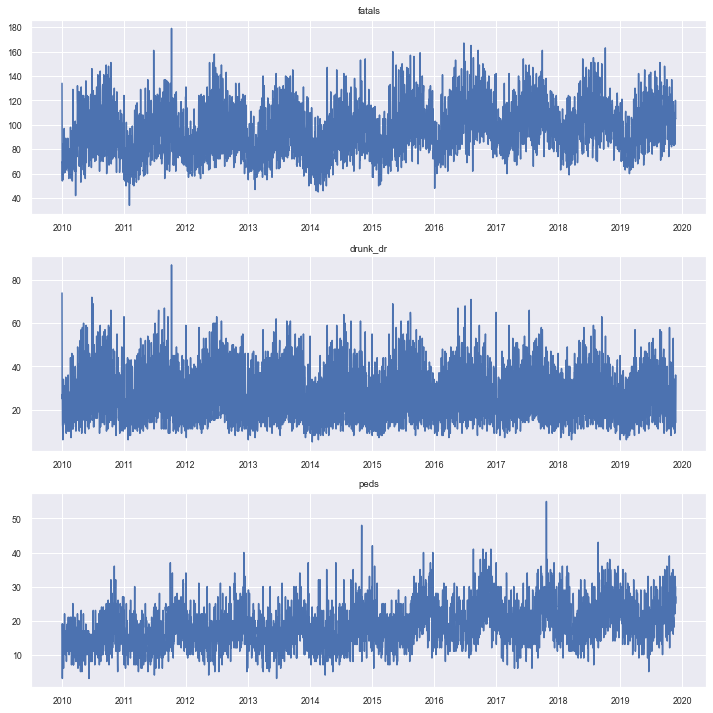

In [361]:
# Plot our training data.
ts_model_d.plot();
plt.tight_layout()

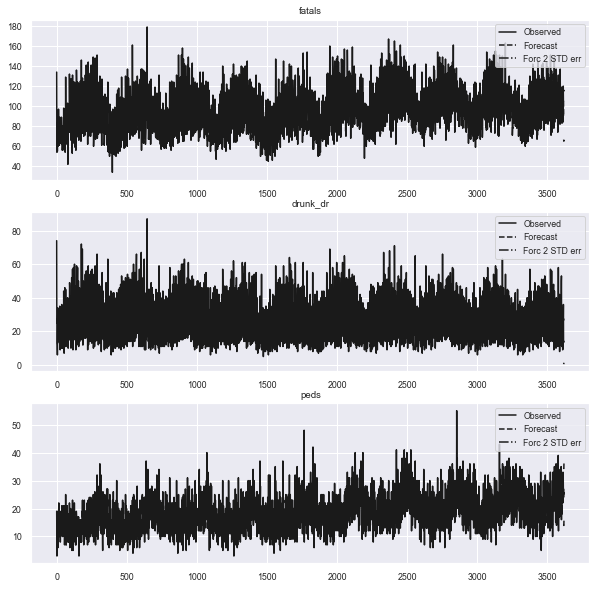

In [362]:
# Plot the forecast looking 3 steps ahead.
ts_model_d.plot_forecast(3);

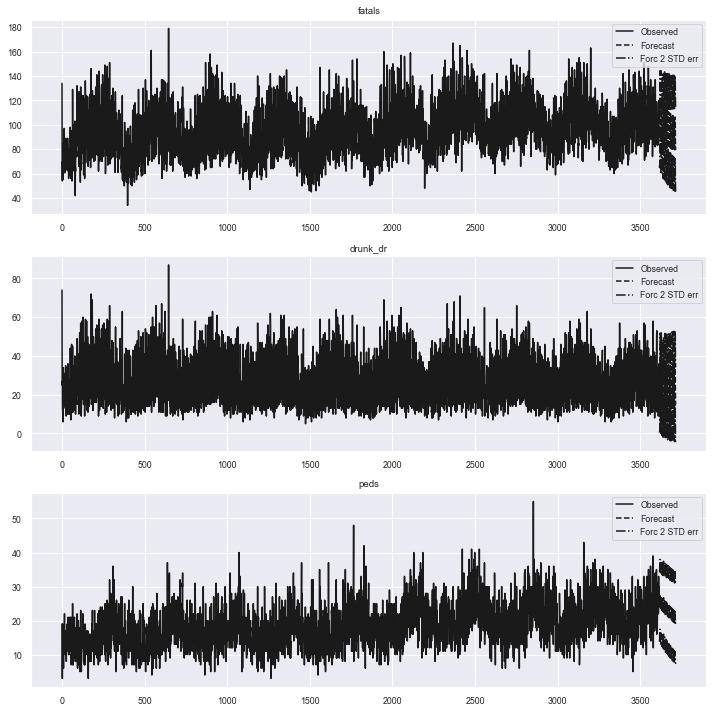

In [363]:
# Plot the forecast looking 12 steps ahead.

ts_model_d.plot_forecast(100);
plt.tight_layout()


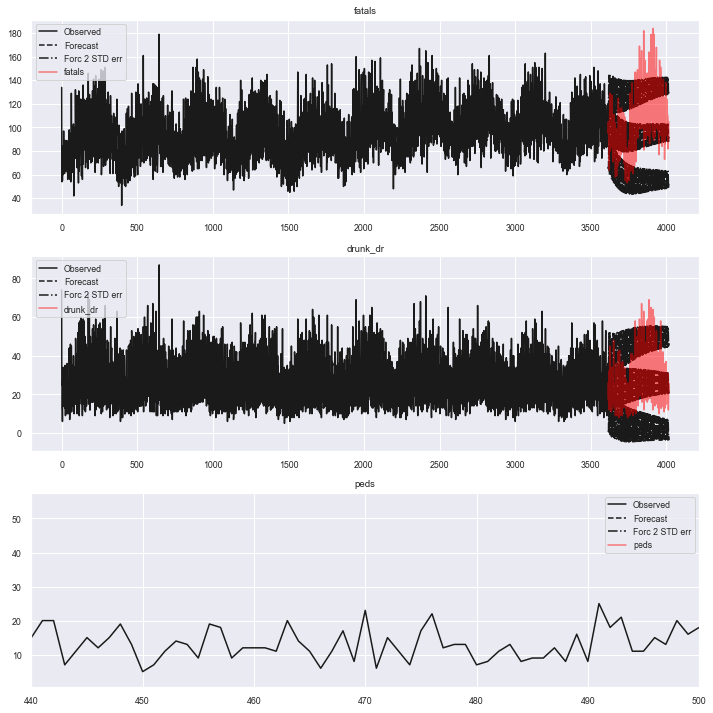

In [364]:
#Plot the forecast for the whole test set (& overlay the actual test values)
model_axes = ts_model_d.plot_forecast(test_d.shape[0]);

plt.xlim(440,500);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test_d.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train_d)
     plot_df.plot(ax = ax, label = test_d.columns[i], color = 'red', alpha = 0.5) # red is actuals y_test
     ax.legend()
     #ax.xlim(400,500)

plt.tight_layout();


In [366]:
# Generate a forecast that matches our testing set.
ts_model_d.forecast(train_d.values, len(test_d))[:10]

array([[ 91.15943491,  13.45171136,  24.2886823 ],
       [ 90.0578414 ,  14.04536645,  24.12917988],
       [ 91.22608166,  14.46525125,  25.88052869],
       [109.2581166 ,  26.09694169,  27.7308615 ],
       [118.93470943,  38.56843345,  27.09271482],
       [108.59356154,  36.41510238,  23.87976999],
       [ 90.35146117,  16.11443327,  23.77933785],
       [ 88.63839572,  15.4903031 ,  23.85221753],
       [ 85.75832234,  14.54812443,  23.49067089],
       [ 88.86515143,  13.69225416,  24.55259244]])

In [367]:
# see values of test
test_d.values[:10]

array([[ 95,  17,  17],
       [105,  26,  29],
       [ 95,  24,  22],
       [ 99,  18,  29],
       [ 99,  32,  28],
       [ 80,  21,  18],
       [ 64,  12,  20],
       [ 77,  14,  20],
       [ 95,  20,  27],
       [ 98,  21,  23]])

#### 6. Evaluate model (and forecasts, if possible).

In [368]:

# We'll use MSE and RMSE

# Save forecasted values
forecast = ts_model_d.forecast(test_d.values, len(test_d))
train_forecast = ts_model_d.forecast(train_d.values, len(train_d))
#forecast = ts_model_d.forecast(train_d.values, len(test_d))

# Loop through columns and get MSE for each
for i in range(test_d.shape[1]):
    print(f'The test MSE on the {test_d.columns[i]} data is: {round(mean_squared_error(test_d.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test_d.shape[1]):
    print(f'The test RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=forecast[:, i]), 4)}')

# Training RMSE
for i in range(train_d.shape[1]):
    print(f'The training RMSE on the {train_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=train_d.values[:, i], y_pred=train_forecast[:, i]), 4)}')

# baseline_RMSE
y_test_baseline_df = pd.DataFrame()

for i in range(test_d.shape[1]):
    y_test_baseline_df[train_d.columns[i]] = [train_d.values[:, i].mean()] * len(test_d) 
    
    print(f'The baseline RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=y_test_baseline_df[train_d.columns[i]]), 4)}')



The test MSE on the fatals data is: 823.5436
The test MSE on the drunk_dr data is: 191.0488
The test MSE on the peds data is: 56.8561
The test RMSE on the fatals data is: 28.6974
The test RMSE on the drunk_dr data is: 13.822
The test RMSE on the peds data is: 7.5403
The training RMSE on the fatals data is: 22.1729
The training RMSE on the drunk_dr data is: 13.8667
The training RMSE on the peds data is: 6.5678
The baseline RMSE on the fatals data is: 26.7651
The baseline RMSE on the drunk_dr data is: 12.3286
The baseline RMSE on the peds data is: 7.7439


#### **Interpretation**: Performance is not good. 
Test RMSE (28) is worse  than Baseline (26)!

#### No undiff required. Do Forecast


In [370]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model_d.forecast(train_d.values, len(test_d)),
                           columns = test_d.columns, index = test_d.index)
forecast_df.head()


,fatals,drunk_dr,peds
date_time,,,
2019-11-26,91.159435,13.451711,24.288682
2019-11-27,90.057841,14.045366,24.129180
2019-11-28,91.226082,14.465251,25.880529
2019-11-29,109.258117,26.096942,27.730862
2019-11-30,118.934709,38.568433,27.092715


In [371]:
# Dont need to undiff, since we never diffed...


In [372]:
## Check out dataframe to see undifferenced forecasts
forecast_df.head()


,fatals,drunk_dr,peds
date_time,,,
2019-11-26,91.159435,13.451711,24.288682
2019-11-27,90.057841,14.045366,24.129180
2019-11-28,91.226082,14.465251,25.880529
2019-11-29,109.258117,26.096942,27.730862
2019-11-30,118.934709,38.568433,27.092715


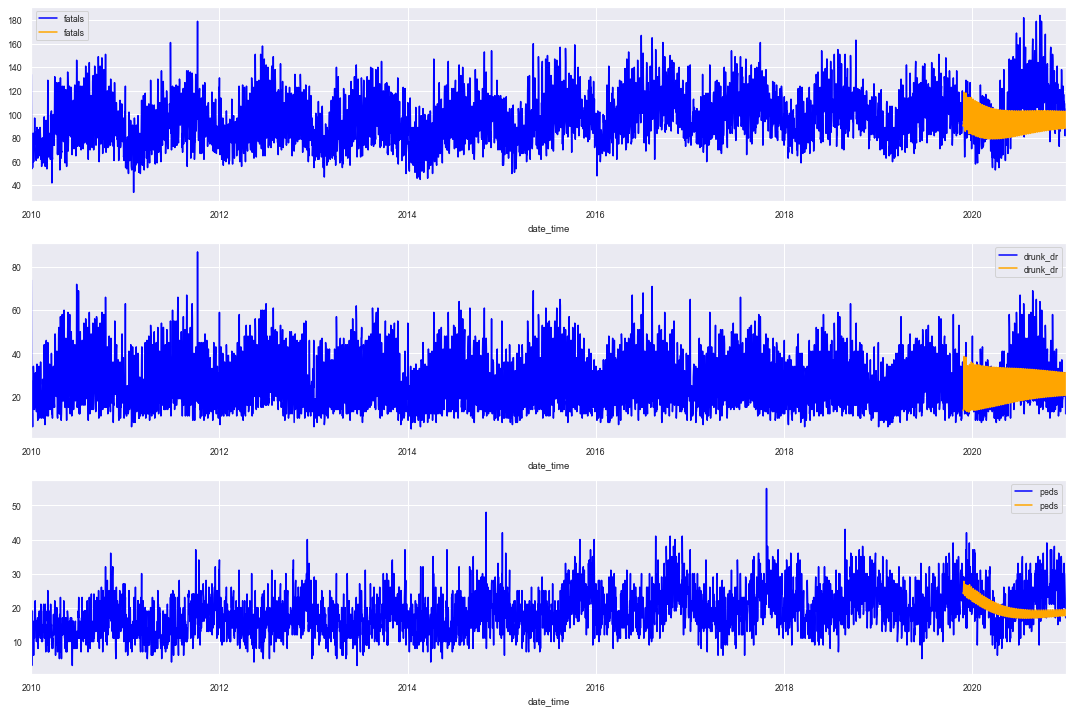

In [374]:
## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,10))

for i, ax in enumerate([ax1,ax2,ax3]):
    df_model_day[df_model_day.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[{df_model_day.columns[i]}].plot(ax = ax, legend = True, color = 'orange')
    #forecast_df[f"forecast_{df_model_week.columns[i]}"].plot(ax = ax, legend = True, color = 'orange')

plt.tight_layout()

#### **Interpretation:** 

Summary of the VAR modeling:   
    - We did monthly, weekly and daily   
    - We did 3 or 5 variables that influence each other as our Y variables  
    - We did a train test split of 5% and 10%   
    - Monthly – needed one diff to make stationary. Weekly and daily were already stationary. 

    
The monthly time series performed the best. 

The test RMSE is substantially better than the baseline RMSE, for all 3 variables. For fatals, the test RMSE of 503 is 34% better than the baseline of 761.9. 
The Mean Absolute Percent Error (MAPE) which shows the percent error indicates that our model’s forecast for fatals is off by 14% on an average month or 503. 

The forecast for the peds is the most accurate, its off by 8% or 67 peds per month, in an average month. 


#### Maybe we can try diff for the weekly and daily series too - future version! 


### We're done with VAR and this notebook. The next notebook will cover RNN! 